# Sentiment Analysis of Yelp Reviews
In the previous notebook, we did data preprocessing and exploratory data analysis. Let's now continue with sentiment analysis. We'll start with unpickling the datasets.

# Importing Dependencies

In [2]:
import pandas as pd
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

# For DTM
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
import string

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, balanced_accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_curve, roc_auc_score
#from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.base import clone
from sklearn.preprocessing import MinMaxScaler

from random import uniform
import datetime as dt
from wordcloud import WordCloud

In [3]:
with open('reviews_cleaned.pkl','rb') as f:
    reviews_cleaned = pickle.load(f)
    
display(reviews_cleaned)

,review_id,business_id,stars,date,text,sentiment
0,vkVSCC7xljjrAI4UGfnKEQ,AEx2SYEUJmTxVVB18LlCwA,5,2016-05-28,super simple place but amazing nonetheless it...,1
1,n6QzIUObkYshz4dz2QRJTw,VR6GpWIda3SfvPC-lg9H3w,5,2016-05-28,small unassuming place that changes their menu...,1
2,MV3CcKScW05u5LVfF6ok0g,CKC0-MOWMqoeWf6s-szl8g,5,2016-05-28,lesters is located in a beautiful neighborhood...,1
3,IXvOzsEMYtiJI0CARmj77Q,ACFtxLv8pGrrxMm6EgjreA,4,2016-05-28,love coming here yes the place always needs t...,1
4,L_9BTb55X0GDtThi6GlZ6w,s2I_Ni76bjJNK9yG60iD-Q,4,2016-05-28,had their chocolate almond croissant and it wa...,1
...,...,...,...,...,...,...
2735206,MV8UTz9z_-4FG-nI8TOjPQ,MRoTUJyR2TVpvDdbOAtBlQ,4,2014-06-26,was in the area and saw a hakka chinese restau...,1
2735207,dyW1tIaWbm_RfCFCffY9yg,Dv0OHpQSL4hOGl2KAEVvlA,2,2012-05-05,not much to write about food is mediocre at b...,0
2735208,ZU2UF0YBkhQFctXH5Mry3A,CMkayuNDHPcd1dxO32kJyA,1,2012-05-24,this place is retarded called on a thursda...,0
2735209,evfB2Xzw4u7aYftWClQfeg,--SrzpvFLwP_YFwB_Cetow,2,2011-10-18,so after reading precilla c review i decided...,0


# 4. Sentiment Analysis
## 4.1 Splitting the Data

In [4]:
X = reviews_cleaned['text']
y = reviews_cleaned['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=1, shuffle=True)

In [5]:
y_train.sum() / len(y_train)

0.7567115504842407

75% of the reviews are positive. This tells us that the baseline accuracy is 75%. Our goal is to have our model perform better than our baseline.

## 4.2 Document-Term Matrix

In [6]:
modal_aux_verbs = set(['has', 'have', 'had', 
                      'does', 'do', 'did', 
                      'be', 'am', 'is', 'are', 'was', 'were', 'being', 'been',
                      'can', 'could', 'will', 'would', 'shall', 'should', 'may', 'might', 'must'])
stop_words = set(stopwords.words('english')).union(set(string.ascii_lowercase)).union(modal_aux_verbs)

cv = CountVectorizer(stop_words=stop_words, ngram_range=(1,2))
X_train = cv.fit_transform(X_train) # Learn the vocabulary dictionary and return document-term matrix
X_test = cv.transform(X_test)

## 4.3 Train and Test

In [7]:
plt.rcParams['figure.figsize'] = [9, 7]

def evaluate_model(model):
    # Predict values for test dataset
    y_pred = model.predict(X_test)

    # Print evaluation metrics
    print("Classification report:")
    print(classification_report(y_test, y_pred, target_names=['negative','positive']))
    print("Balanced accuracy score: ", balanced_accuracy_score(y_test, y_pred))
    
    # Compute and plot the confusion matrix
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=['Negative','Positive'],
                                            normalize='all', values_format='.2%', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()

### 4.3.1 Naive Bayes

Classification report:
              precision    recall  f1-score   support

    negative       0.92      0.85      0.89    132913
    positive       0.95      0.98      0.97    414130

    accuracy                           0.95    547043
   macro avg       0.94      0.91      0.93    547043
weighted avg       0.95      0.95      0.95    547043

Balanced accuracy score:  0.9146333147855525


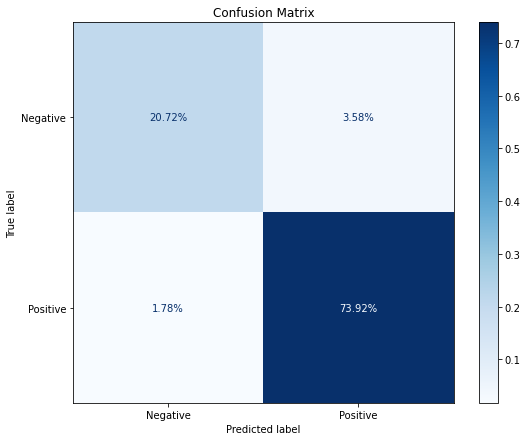

In [8]:
nb = MultinomialNB()
nb.fit(X_train, y_train)
evaluate_model(nb)

<b>Our Naive Bayes model performs at 91.46% accuracy</b>, which is a 16% improvement over our baseline! 

<b>Precision</b> tells us that out of all the reviews the model predicted to be positive, 95% actually were. Similarly, out of all the reviews the model predicted to be negative, 92% actually were.

<b>Recall</b> tells us that out of all the reviews that were actually positive, the model predicted this label correctly for 98% of the reviews! On the other hand, out of all the reviews that were actually negative, the model accurately predicted them for 85% of the reviews--a little less but still great.

Since we're doing binary classification, recall of the positive class is also known as sensitivity (true positive rate) and recall of the negative class is specificity (true negative rate). It makes sense that our sensitivity is high (98%) and our specificity is comparatively low (85%), since our dataset consists of predominantly positive reviews. 

<b>F1 score</b> is a weighted harmonic mean of precision and recall, and hence is a class-balanced accuracy measure. Our model is good at predicting true positives, but it's predicting true negatives at a much lower rate. 

F1 score is a great evaluation metric for imbalanced datasets like ours, but both positive and negative reviews are equally important to us, so we're using balanced accuracy as our metric. 

<b>Support</b> simply tells us that in our test dataset, 132,913 reviews are negative and 414,130 are positive. 

### 4.3.2 Logistic Regression

Classification report:
              precision    recall  f1-score   support

    negative       0.94      0.92      0.93    132913
    positive       0.98      0.98      0.98    414130

    accuracy                           0.97    547043
   macro avg       0.96      0.95      0.96    547043
weighted avg       0.97      0.97      0.97    547043

Balanced accuracy score:  0.9528490569514624


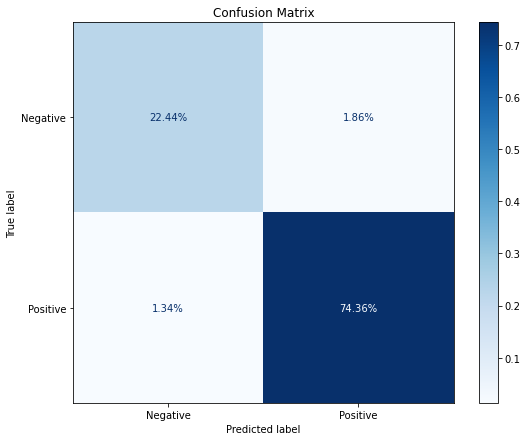

In [9]:
lr = LogisticRegression(random_state=1, max_iter=2000)
lr.fit(X_train,y_train)
evaluate_model(lr)

Our <b>Logistic Regression</b> model performs better (at <b>95.28% balanced accuracy!</b>) than the Naive Bayes model on all metrics—more importantly for negative reviews, shortening the gap between the positive and negative recall.

### 4.3.3 SVM

Classification report:
              precision    recall  f1-score   support

    negative       0.93      0.92      0.93    132913
    positive       0.97      0.98      0.98    414130

    accuracy                           0.96    547043
   macro avg       0.95      0.95      0.95    547043
weighted avg       0.96      0.96      0.96    547043

Balanced accuracy score:  0.9497245833130166


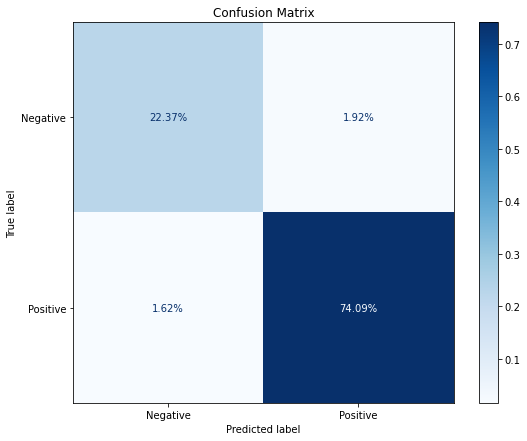

In [10]:
svm = LinearSVC(random_state=1, max_iter=4000)
svm.fit(X_train,y_train)
evaluate_model(svm)

Our <b>SVC</b> model performs at a slightly lower performance (if not the same) on all metrics compared to the Linear Regression model. The SVC model has a <b>94.97% balanced accuracy</b>.

### 4.3.4 ROC Curve

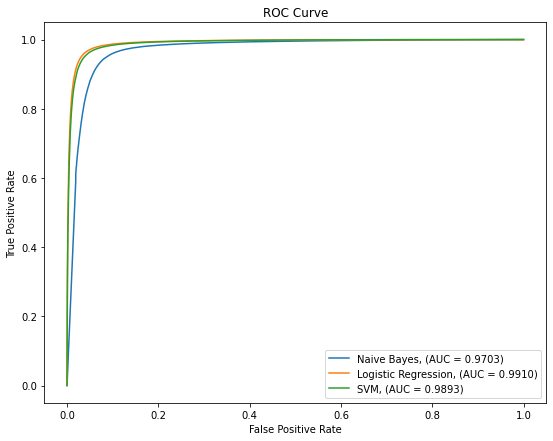

In [11]:
models = {nb: "Naive Bayes", lr: "Logistic Regression", svm: "SVM"}

def plot_roc_curve(models):
    for model in models.keys():
        if model==svm:
            y_pred = svm._predict_proba_lr(X_test)[:,1]
#             clf = CalibratedClassifierCV(svm, cv="prefit")
#             clf.fit(X_train, y_train)
#             y_pred = clf.predict_proba(X_test)[:,1]
        else:
            y_pred = model.predict_proba(X_test)[:,1]
        
        fpr, tpr, _ = roc_curve(y_test, y_pred)
        auc = roc_auc_score(y_test, y_pred)
        plt.plot(fpr, tpr, label=f"{models[model]}, (AUC = {auc:.4f})")
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()
    
plot_roc_curve(models)

## 4.4 Model Improvement
We've done a simple train and test on 3 models and found that Logistic Regression was the best model with a  balanced accuracy score of 95% on the test set. Let's now do cross-validation to better estimate model performance and tune hyperparameters of the best model. We'll then apply it to the test set and compare the score to our initial findings.

In [12]:
def cv_models(models):
    for model in models.keys():
        print(models[model]) #name
        
        scores = cross_val_score(model, X_train, y_train, cv=5, scoring='balanced_accuracy')
        print(f"validation score: {scores.mean():.5f} with a standard deviation of {scores.std():.5f}\n")
        
cv_models(models)

Naive Bayes
validation score: 0.91728 with a standard deviation of 0.00053

Logistic Regression
validation score: 0.95169 with a standard deviation of 0.00037

SVM
validation score: 0.94894 with a standard deviation of 0.00046



In [11]:
#best model is lr, tune hyperparameters now, then we use best model on test set

hp = {
        "C": [uniform(0.01,10)],
        "random_state": [1]        #reproducibility of grid search asks us to set random state in param_grid
     }
grid = GridSearchCV(lr, param_grid=hp, cv=5)
grid.fit(X_train, y_train)
print("Best params:", grid.best_params_)
print("Best validation score:", grid.best_score_)

Best params: {'C': 1.1887604246598382, 'random_state': 1}
Best validation score: 0.9671821358907102


We've increased our validation score by about 1.5%.

Classification report:
              precision    recall  f1-score   support

    negative       0.94      0.92      0.93    132913
    positive       0.98      0.98      0.98    414130

    accuracy                           0.97    547043
   macro avg       0.96      0.95      0.96    547043
weighted avg       0.97      0.97      0.97    547043

Balanced accuracy score:  0.9528390805711914


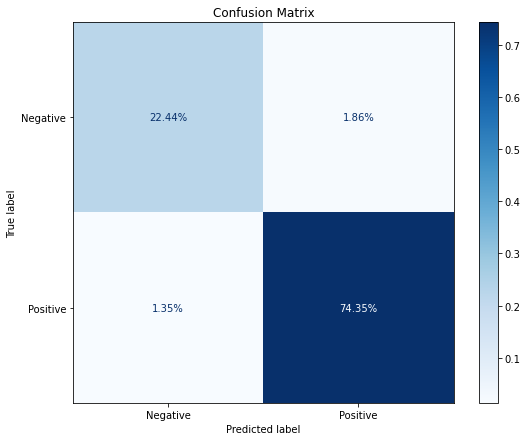

In [12]:
lr = LogisticRegression(random_state=1, max_iter=2000, C=grid.best_params_['C'])
lr.fit(X_train,y_train)
evaluate_model(lr)

The test score is pretty close to the validation score. The balanced accuracy test score is essentially the same as our initial findings: 95.28%.

## 4.5 Feature Importance

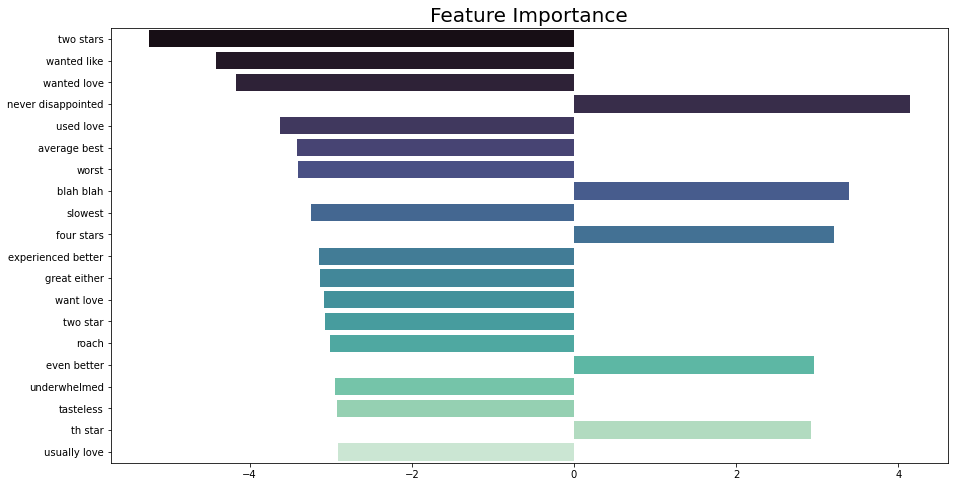

In [14]:
plt.rcParams['figure.figsize'] = (15,8)

def plot_feature_importance(model, vectorizer, n):
    # Get top n important features 
    #(absolute value so able to take into account negative scores that indicate a feature that predicts class 0)
    top_n_features = pd.Series(abs(model.coef_[0])).sort_values(ascending=False).head(n)

    # Names of the top n features
    feature_names = vectorizer.get_feature_names_out()[top_n_features.index]

    # Plot important features
    sns.barplot(y=feature_names, x=model.coef_[0][top_n_features.index], palette='mako', orient='h')
    plt.title("Feature Importance", fontsize=20)

    plt.show()
    
plot_feature_importance(lr, cv, 20)

This leads us to believe that a key factor of our high score is the bigrams we incorporated in our document-term matrix.

# 5. Sentiment Analysis of a Specific Restaurant

## 5.1 Importing Data

In [15]:
# load the restaurants dataset
with open('business_cleaned.pkl','rb') as f:
    business_cleaned = pickle.load(f)

## 5.2 EDA
Let's take a look at the distribution of `review_count` for restaurants.

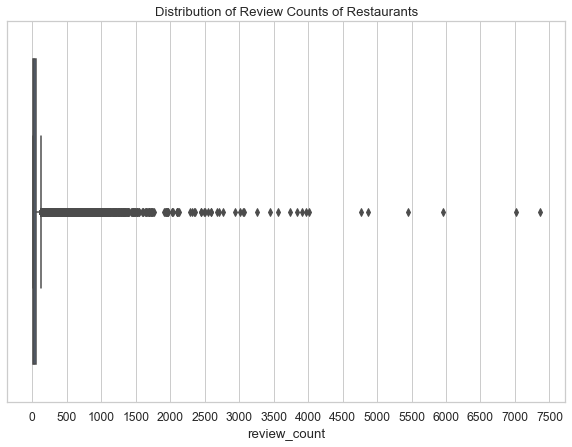

In [16]:
plt.rcParams['figure.figsize'] = (10,7)
sns.set(font_scale=1.1)
sns.set_style("whitegrid")

sns.boxplot(data=business_cleaned, x='review_count')
plt.xticks(np.arange(0,8000,step=500))
plt.title("Distribution of Review Counts of Restaurants")
plt.show()

Most restaurants seem to have fewer than 200 reviews. Let's take a look into restaurants with a high number of reviews yet less-than-stellar rating. In our case, we'll consider any average rating below 4 as less than stellar.

In [17]:
print("Top 10 most reviewed restaurants with less than 4 stars:")
business_cleaned[business_cleaned.stars<4].sort_values("review_count", ascending=False).head(10)

Top 10 most reviewed restaurants with less than 4 stars:


,business_id,name,city,state,stars,review_count,is_open,categories
22029,K7lWdNUhCbcnEvI0NhGewg,"""Wicked Spoon""",Las Vegas,NV,3.5,5950,1,Buffets;Breakfast & Brunch;Restaurants
25381,2weQS-RnoOBhb1KsHKyoSQ,"""The Buffet""",Las Vegas,NV,3.5,4018,1,Buffets;Restaurants
6563,eoHdUeQDNgQ6WYEnP2aiRw,"""Serendipity 3""",Las Vegas,NV,3.0,3910,0,Social Clubs;Arts & Entertainment;American (Tr...
29249,ujHiaprwCQ5ewziu0Vi9rw,"""The Buffet at Bellagio""",Las Vegas,NV,3.5,3838,1,Buffets;Restaurants;American (New)
3283,El4FC8jcawUVgw_0EIcbaQ,"""MGM Grand Hotel""",Las Vegas,NV,3.0,3444,1,Restaurants;Arts & Entertainment;Hotels;Event ...
11295,HhVmDybpU7L50Kb5A0jXTg,"""Guy Fieri's Vegas Kitchen & Bar""",Las Vegas,NV,3.5,2674,1,American (New);Burgers;Restaurants;Pubs;Nightl...
52225,yfxDa8RFOvJPQh0rNtakHA,"""Pho Kim Long""",Las Vegas,NV,3.5,2594,1,Vietnamese;Chinese;Restaurants
37349,YJ8ljUhLsz6CtT_2ORNFmg,"""Gordon Ramsay Pub & Grill""",Las Vegas,NV,3.5,2502,1,Gastropubs;Fish & Chips;Nightlife;Restaurants;...
1604,G-5kEa6E6PD5fkBRuA7k9Q,"""Giada""",Las Vegas,NV,3.5,2349,1,Italian;Restaurants
43672,ZkGDCVKSdf8m76cnnalL-A,"""Le Village Buffet""",Las Vegas,NV,3.0,2108,1,Sandwiches;Restaurants;Buffets;Breakfast & Brunch


It's interesting to see how a Gordon Ramsay restaurant has a 3.5 star rating. Let's plot its expanding average rating over time.

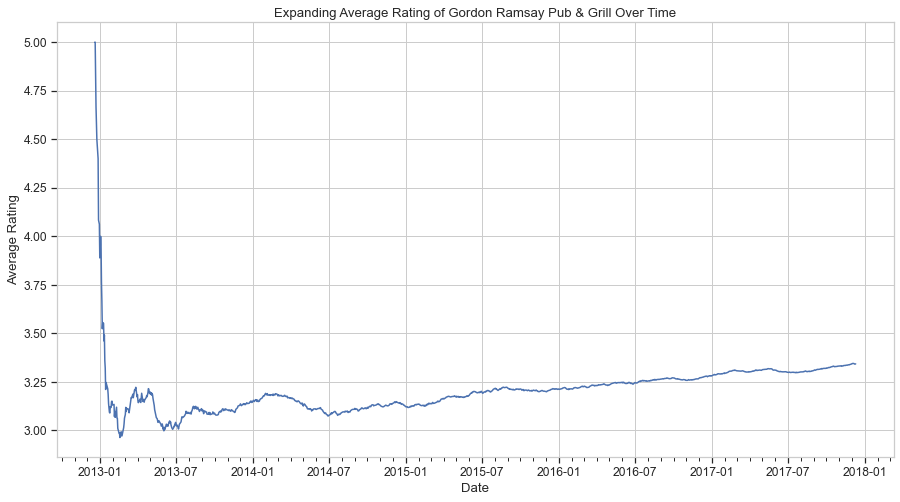

In [18]:
plt.rcParams['figure.figsize'] = (15,8)
plt.rcParams.update({"xtick.bottom" : True, "ytick.left" : True})

# Convert date col to datetime object
reviews_cleaned['date'] = pd.to_datetime(reviews_cleaned['date'], format='%Y-%m-%d')

# Singling out the restaurant in reviews_cleaned dataset
res_id = (business_cleaned.loc[business_cleaned['name'].str.contains("Gordon Ramsay Pub"), 'business_id']
          .values[0])
res = reviews_cleaned[reviews_cleaned['business_id']==res_id]

# Take the mean of ratings per date so no duplicate indices(date), 
# then take the mean of ratings from the very first review up to the date (expanding window)
avg_rating_by_date = res.groupby('date')['stars'].mean().expanding().mean()

# Plot expanding average rating over time
fig, ax = plt.subplots()
ax.plot(avg_rating_by_date.index, avg_rating_by_date)

# Set date ticks
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
ax.xaxis.set_minor_locator(mdates.MonthLocator())

plt.xlabel("Date")
plt.ylabel("Average Rating")
plt.title("Expanding Average Rating of Gordon Ramsay Pub & Grill Over Time")

plt.show()

We see that the restaurant started with a 5-star rating but within less than a month was in the 3-star range. Although the restaurant had a slight upward trend after that, it stayed in the 3-star range till the end. 

Let's find the exact date of the lowest dip in average rating, which is between February and March as we can see on the plot above.

In [19]:
# finding the date of when the restaurant had the lowest avg rating
avg_rating_by_date.sort_values().head(10)

date
2013-02-17    2.963566
2013-02-19    2.970741
2013-02-22    2.971986
2013-02-18    2.981439
2013-02-15    2.986179
2013-02-16    2.986508
2013-02-20    2.993116
2013-06-02    2.998132
2013-06-23    3.005890
2013-06-05    3.006583
Name: stars, dtype: float64

We can see more clearly below the lowest average rating (of just below 3 stars) the restaurant had on 2013-02-17.
We can also see how it took only about half a month for the restaurant to hit a 3.5 star rating, but note that a [Berkeley study](https://techcrunch.com/2012/09/02/berkeley-study-half-star-change-in-yelp-rating-can-make-or-break-a-restaurant/) found that a business will get rated by Yelp 3.5 once the ratings hit 3.74.

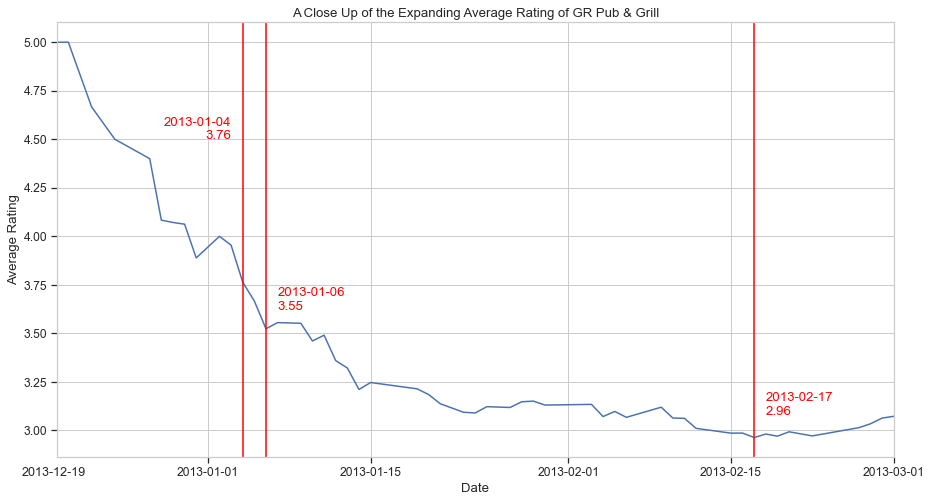

In [20]:
plt.plot(avg_rating_by_date.index, avg_rating_by_date)
plt.xlim([dt.date(2012,12,19), dt.date(2013, 3, 1)])
plt.text(dt.date(2012,12,16), 2.766, "2013-12-19", fontsize=12.5)

# date of lowest avg rating
plt.axvline(dt.date(2013,2,17), color='red')
plt.text(dt.date(2013,2,18), 3.08, "2013-02-17\n2.96", color="red")

# date when rating hit 3.5 stars
plt.axvline(dt.date(2013,1,6), color='red')
plt.text(dt.date(2013,1,7), 3.62, "2013-01-06\n3.55", color="red")

# date when rating is close to showing up as 3.5
plt.axvline(dt.date(2013,1,4), color='red')
plt.text(dt.date(2013,1,3), 4.5, "2013-01-04\n3.76", color="red", ha='right')

plt.xlabel("Date")
plt.ylabel("Average Rating")
plt.title("A Close Up of the Expanding Average Rating of GR Pub & Grill")

plt.show()

We can see below that the average rating stays below 3 stars until 2013-02-22. Let's filter the restaurant reviews from beginning up to 2013-02-22.

In [21]:
avg_rating_by_date[(avg_rating_by_date.index.year==2013)
                  & (avg_rating_by_date.index.month==2)
                  & ((avg_rating_by_date.index.day >= 12) & (avg_rating_by_date.index.day <= 26))]

date
2013-02-12    3.010833
2013-02-15    2.986179
2013-02-16    2.986508
2013-02-17    2.963566
2013-02-18    2.981439
2013-02-19    2.970741
2013-02-20    2.993116
2013-02-22    2.971986
2013-02-26    3.014236
Name: stars, dtype: float64

In [22]:
# get all reviews up to 2/22
# we can take a closer look at what made the avg rating hit the lowest point of 2.96 and stay under 3 stars
reviews_2_22 = reviews_cleaned.loc[(reviews_cleaned['business_id']==res_id) 
                    & (reviews_cleaned['date'] <= pd.to_datetime(dt.date(2013, 2, 22)))]

Let's first take a look at the frequency of ratings up till 2013-02-22. For this, we'll have to unpickle the `reviews` dataset containing 3-star reviews.

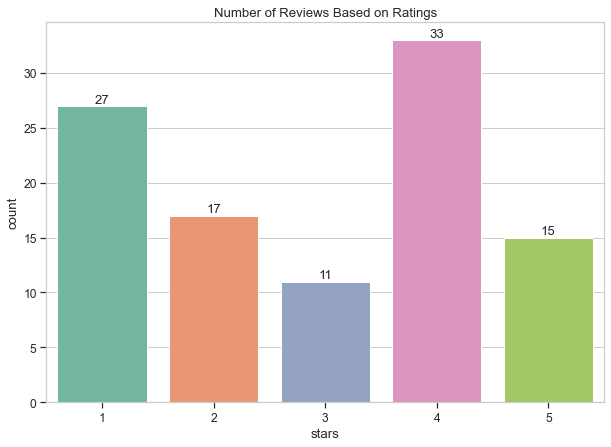

In [23]:
plt.rcParams['figure.figsize'] = (10,7)

with open('reviews_cleaned_w_3_stars.pkl','rb') as f:
    temp = pickle.load(f)

# Convert date col to datetime object
temp['date'] = pd.to_datetime(temp['date'], format='%Y-%m-%d')

# Filter temp reviews dataset to reflect only the restaurant up to 2013-2-22
temp = temp.loc[(temp['business_id']==res_id) 
                    & (temp['date'] <= pd.to_datetime(dt.date(2013, 2, 22)))]

ax = sns.countplot(data=temp, x='stars', palette='Set2')
ax.bar_label(ax.containers[0])
ax.set_title("Number of Reviews Based on Ratings")

plt.show()

3-star reviews were the least frequent. Most reviews rated the restaurant either 1-star or 4-star, which means most customers either hated it or liked it (defining 5 stars as customers loving the restaurant).

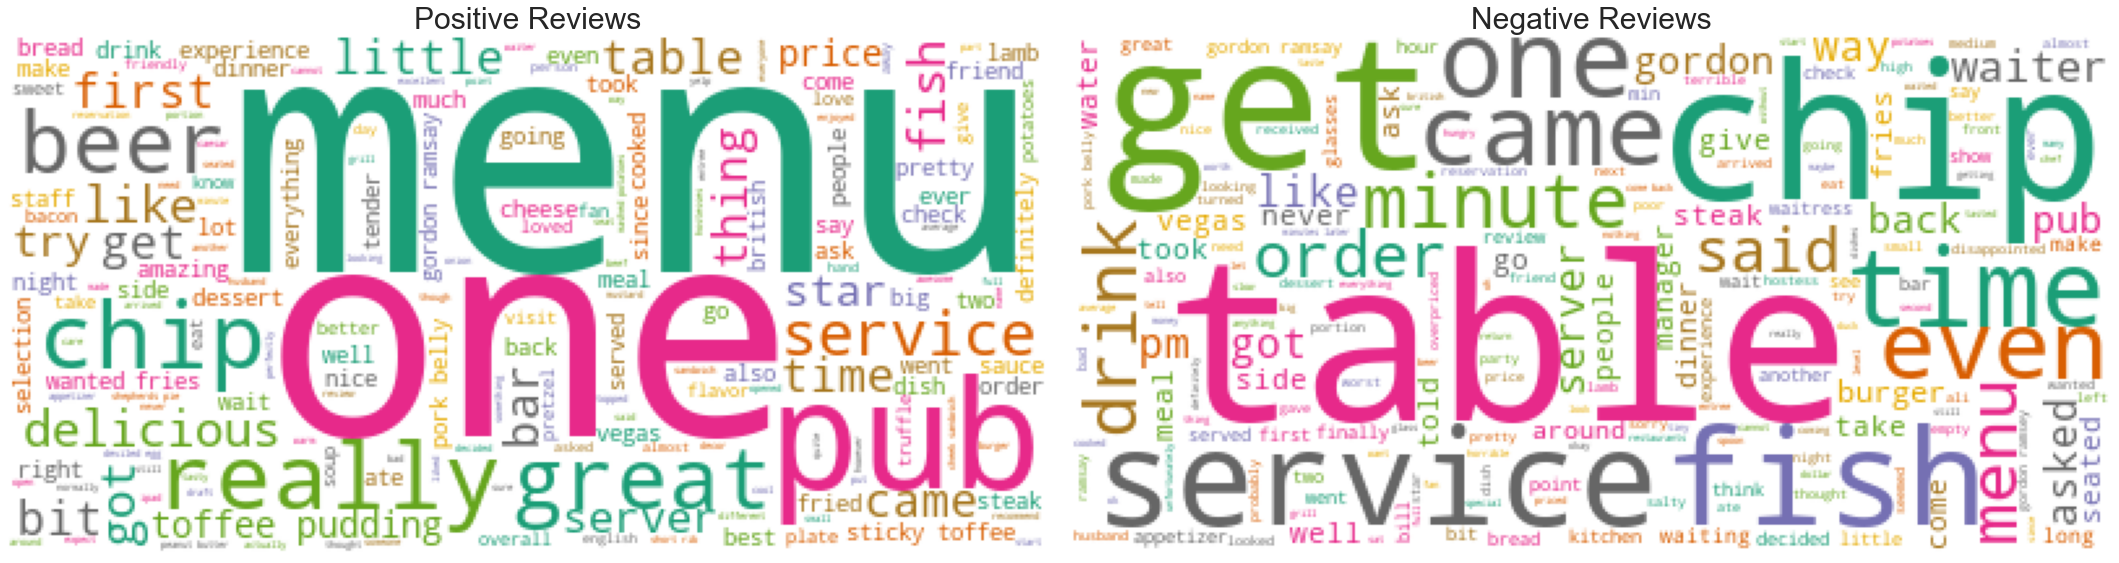

In [25]:
# Top common words between positive and negative reviews, didn't help to differentiate in word clouds
common_words=['good','food','restaurant','us','ordered','place']

# add alphabet characters, auxiliary verbs, and modal auxiliary verbs to english stop words
modal_aux_verbs = set(['has', 'have', 'had', 
                      'does', 'do', 'did', 
                      'be', 'am', 'is', 'are', 'was', 'were', 'being', 'been',
                      'can', 'could', 'will', 'would', 'shall', 'should', 'may', 'might', 'must'])
stop_words = (set(stopwords.words('english')).union(set(string.ascii_lowercase))
                                             .union(modal_aux_verbs)
                                             .union(set(common_words))
             )

fig = plt.figure(figsize=(30,30))
for sentiment in [0,1]:
    # Filter the reviews per sentiment
    rev = reviews_2_22[reviews_2_22['sentiment']==sentiment]['text']
    
    # Create word cloud, want positive reviews to be on the left side
    place = (1 if sentiment else 2)
    ax = fig.add_subplot(1,2,place)
    wc = (WordCloud(background_color="white", colormap="Dark2", random_state=1, stopwords=stop_words)
          .generate(" ".join(rev)))
    
    # Plot word clouds
    fig.tight_layout()
    ax.imshow(wc)
    ax.set_title(f"{'Positive' if sentiment else 'Negative'} Reviews", fontsize=30)
    ax.axis('off')

Although the word "chip" shows up in both positive and negative reviews, we can reason that it shows up more in negative reviews because people complain about the chips in the fish and chips dish (as well as the fish as we can see in the word cloud). We can also use the same reasoning for "service." The wait time is probably long as well as we see the words "time," "minute," and "long" in the negative reviews word cloud.

We can see complaints about the fish and chips below.

In [26]:
# reviews_2_22[(reviews_2_22.text.str.contains("chips")) & (reviews_2_22.sentiment==0)]

print(reviews_2_22.loc[13040,'text'])
print("sentiment:",reviews_2_22.loc[13040,'sentiment'],"\n")

print(reviews_2_22.loc[66114,'text'])
print("sentiment:",reviews_2_22.loc[66114,'sentiment'],"\n")

print(reviews_2_22.loc[528746,'text'])
print("sentiment:",reviews_2_22.loc[528746,'sentiment'],"\n")

being a big fan of gordon ramsey and his steakhouse  i had high hopes for this place  my wife and i ate there on christmas eve   very disappointed  we sat on the pub side and we were not even offered to look at the pub menu  it was not until we ordered that i realized there was a second menu  we both chose the fish and chips  greasy thick batter on flavorless fish  chips were these thick cut and i do not mean steak like fries  i mean these block rectangular potatoes with no seasoning   if you want fish and chips go to his steakhouse at paris     also  the place just opened and vegas was packed but this place was half empty at  pm   lousy vibe and music  the only positive were the cocktails   much better choices in vegas 
sentiment: 0 

as a brit i was embarrassed to eat here   it was terrible  overpriced    for a side of chips   potatoes  food not freshly prepared dry and not very warm snapper  mussels and clams old and cold  very disappointing everything gordon ramsey tells establishm

## 5.3 Applying Model to the Restaurant

In [239]:
# fit lr to GR reviews

# document-term matrix for GR Pub & Grill
cv_GR = CountVectorizer(stop_words=stop_words, ngram_range=(1,2))
X_GR = cv_GR.fit_transform(res['text'])
y_GR = res['sentiment']

# fit lr model to dtm
lr_GR = clone(lr)
lr_GR.fit(X_GR, y_GR)

LogisticRegression(C=1.1887604246598382, max_iter=2000, random_state=1)

Let's sort the features by importance with names in a DataFrame for easier access.

In [240]:
# Sort feature coefs and names in a DataFrame by importance
# We keep original index of features from the model/vectorizer to access model/vectorizer
sorted_coefs_GR = pd.DataFrame(abs(lr_GR.coef_[0])).sort_values(by=0, ascending=False).reset_index()
feature_names_GR = pd.Series(cv_GR.get_feature_names_out()[sorted_coefs_GR['index']])
features_df_GR = pd.concat([sorted_coefs_GR, feature_names_GR], axis=1)
features_df_GR.columns = ['index','coef','feature']

# Drop words that indicate basic sentiment in order to reveal sentiment of specific business aspects
to_drop = ['amazing','great','disappointing','horrible','excellent',
          'disappointed','disappointment','awesome','terrible','loved',
          'mediocre','worst','fantastic','perfect','better',
          'incredible','awful','nice','gordon','best',
          'fun','fine','perfectly','perfection','excited',
          'enjoyed',
           #not exactly basic sentiment indicators but doesn't really help our analysis
          'unfortunately','definitely','even','maybe','never','asked']
features_df_GR = features_df_GR[~features_df_GR['feature'].isin(to_drop)]

# Replace absolute coefs in df with actual coefs
features_df_GR['coef'] = lr_GR.coef_[0][features_df_GR['index']]

features_df_GR.head()

,index,coef,feature
1,21052,1.468103,delicious
6,16644,-1.102394,cold
9,9308,-1.080622,bland
10,59198,-1.037115,overpriced
11,57172,-0.979418,ok


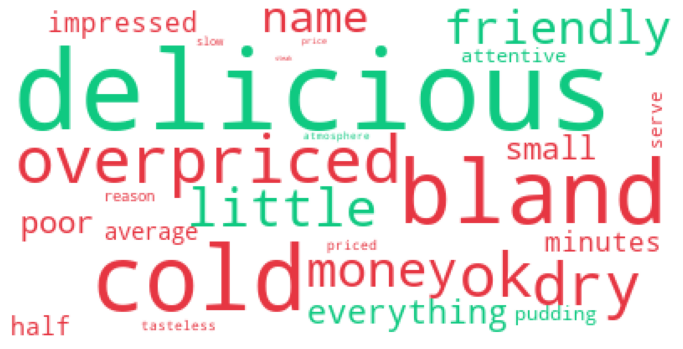

In [241]:
# Plot word cloud of sentiment of specific business aspects that drive customer perception of business
plt.rcParams['figure.figsize'] = (12,10)

# scale data bc of negative coefs (we can't have negative numbers for freqs)
data = abs(features_df_GR['coef'].head(30))
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform([[x] for x in data])

top_features_scaled_dict = pd.DataFrame(scaled, features_df_GR['feature'].head(30)).to_dict()

def color_word(word, font_size, position, orientation, font_path, random_state=None, **kwargs):
    """
        colors word in word cloud depending on the sign of the actual coef of the feature 
    """
    word_coef = features_df_GR.loc[features_df_GR['feature']==word, 'coef'].item()
    if word_coef > 0:
        return (15, 201, 129) #green
    return (230, 54, 66)      #red

# Plot word cloud
wc_ = (WordCloud(background_color="white", color_func=color_word, random_state=42)
                .generate_from_frequencies(top_features_scaled_dict[0]))
fig.tight_layout()
plt.imshow(wc_)
plt.axis('off')
plt.show()

Some customers find the food <b>delicious</b> at Gordon Ramsay Pub & Grill, the service <b>friendly</b> and <b>attentive</b>, and the <b>atmosphere</b> good. They also seem to like the <b>pudding</b> on the menu. Other than these, it seems that there's a lot of negative sentiment towards the restaurant. What drives this sentiment, and bringing the rating down, is how other customers find the food <b>overpriced</b>, <b>bland</b>, <b>cold</b>, and <b>dry</b>. We can reason from the mentions of <b>poor</b> and <b>minutes</b> that there are customers who find the service to be poor and slow. The latter can also be reasoned for how long the food took to get to the customers. 

Let's look at these specific restaurant aspects in a clearer format.

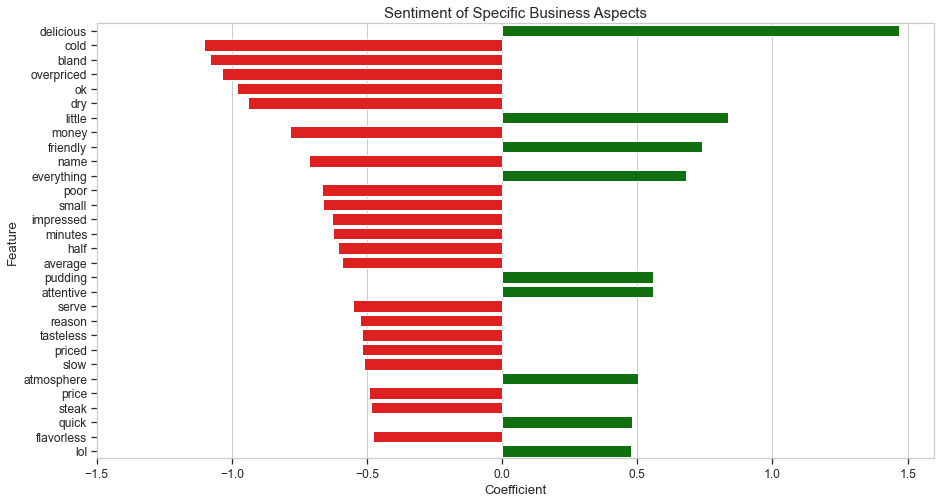

In [242]:
# Plot feature importance of specific business aspects (so we can see sentiment more clearly)
plt.rcParams['figure.figsize'] = (15,8)

sns.barplot(y = features_df_GR['feature'].head(30), 
            x = features_df_GR['coef']   .head(30), 
            palette = (features_df_GR['coef'] > 0).map({True: 'green',
                                                        False: 'red'}
                                                      )
           )
plt.title("Sentiment of Specific Business Aspects", fontsize=15)
plt.xlabel("Coefficient")
plt.ylabel("Feature")
plt.xticks(np.arange(-1.5,1.51,0.5))
plt.show()

What we mostly missed from the word cloud is how some customers did not like the <b>steak</b> and how the food is <b>tasteless</b> and <b>flavorless</b> in general, though this already falls under <b>bland</b>.

# 6. Conclusion
In this project, we've found that most customers leave a positive review for restaurants and that negative reviews are more opinionated and descriptive than positive reviews. 

Logistic Regression was our best model with a balanced accuracy score of 0.95284. We chose balanced accuracy score as our evaluation metric, since our dataset was imbalanced and both classes are equally important to us. 

We applied this model to the restaurant Gordon Ramsay Pub & Grill in order to find out specific aspects that drive overall customer perception of the restaurant. We've found that the overpriced, bland food and the poor, slow service brought the Yelp rating of the restaurant down. 